# Training the model

Now all the time-intensive preprocessing steps are over, it is quite easy to preparing the training data and start training the model.

First we combine the ERA5 and Ameriflux data:

In [1]:
from src import generate_training_data
from pathlib import Path
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=2)

In [4]:
ds = generate_training_data.combine_era5_fluxnet(
    preprocessed_ameriflux_data=Path("/home/yangliu/Excited/EXCITED_prepped_data/NEE_ameriflux_transcom2.nc"),
    preprocessed_era5_folder=Path("/home/yangliu/Excited/EXCITED_prepped_data/prep_era5"),
)

The resulting xarray dataset contains all the variables from the preprocessed ameriflux data, as well as the preprocessed ERA5 variables, sorted per site.

This dataset can be modified to add, for example, the sum of incoming solar radiation over the last 6 hours.

In [5]:
ds

<xarray.Dataset>
Dimensions:         (time: 271755, site: 61)
Coordinates:
  * time            (time) datetime64[ns] 1991-01-01T06:00:00 ... 2022-01-01T...
  * site            (site) object 'CA-Cbo' 'CA-DB2' ... 'US-Wjs' 'US-xBR'
Data variables: (12/13)
    GPP_NT_VUT_REF  (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    GPP_DT_VUT_REF  (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    NEE_VUT_REF     (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    latitude        (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude       (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d2m             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    ...              ...
    msshf           (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    sp              (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    ssr             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    str             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    t2m             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    tp              (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>

However, for input into `sklearn`, having the data in a pandas dataframe is more practical:

In [6]:
df_train = generate_training_data.generate_training_df(ds)

Exception ignored in: <function CachingFileManager.__del__ at 0x7faaf1abfd00>
Traceback (most recent call last):
  File "/home/yangliu/venv/excited/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 249, in __del__
    self.close(needs_lock=False)
  File "/home/yangliu/venv/excited/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 233, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2622, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2585, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2029, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


In [7]:
df_train.head(3)

,site,GPP_NT_VUT_REF,GPP_DT_VUT_REF,NEE_VUT_REF,latitude,longitude,d2m,mslhf,msshf,sp,ssr,str,t2m,tp
time,,,,,,,,,,,,,,
1995-01-01 00:00:00,US-Ha1,-0.971051,0.0,2.10000,42.5378,-72.1715,264.466522,-4.967041,54.720062,99350.437500,-0.125,-210559.81250,272.810333,1.862645e-09
1995-01-01 01:00:00,US-Ha1,0.008659,0.0,1.16182,42.5378,-72.1715,265.805634,-3.780518,53.489761,99309.539062,-0.125,-230118.34375,272.771973,1.862645e-09
1995-01-01 02:00:00,US-Ha1,0.334134,0.0,0.80000,42.5378,-72.1715,267.322388,-2.971527,50.069946,99251.554688,-0.125,-204781.68750,273.040466,1.862645e-09


Note that this dataframe is a "tidy" dataframe, where all dimensions/coordinates have been flattened.
This data is now ready to train a machine learning model.

In [8]:
from sklearn.ensemble import RandomForestRegressor

y_key = "GPP_DT_VUT_REF"
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m"]

site_mask = df_train["site"] != "US-Ha1"

df_reduced = df_train[::24]  # Select a reduced size dataset for easier testing.
site_mask_r = df_reduced["site"] != "US-Ha1"
X_train= df_reduced[X_keys][site_mask_r]
y_train = df_reduced[y_key][site_mask_r]
X_test = df_train[X_keys][~site_mask]
y_test = df_train[y_key][~site_mask]

Let's train the random forest regressor:

In [11]:
rfr = RandomForestRegressor()
rfr.fit(X_train[:1000], y_train[:1000])

RandomForestRegressor()

We left one site out for validation. We can compute the score as follows:

In [12]:
rfr.score(X_test, y_test)

0.6994650363806378

Let's see what the model predicts, as diurnal pattern

<Axes: xlabel='time'>

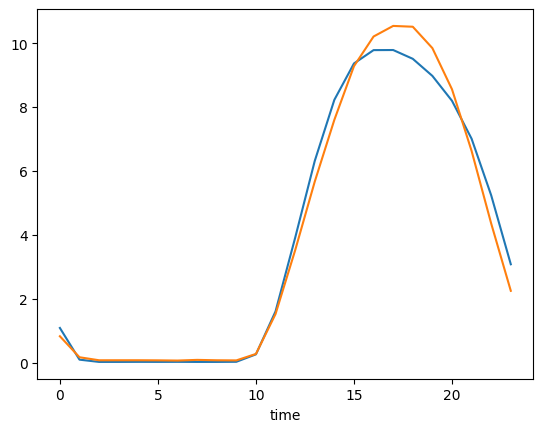

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
df_results = pd.DataFrame(y_test.rename("y_test"))
df_results["predict"] = rfr.predict(X_test)
df_results["y_test"].groupby(df_results.index.hour).mean().plot()
df_results["predict"].groupby(df_results.index.hour).mean().plot()

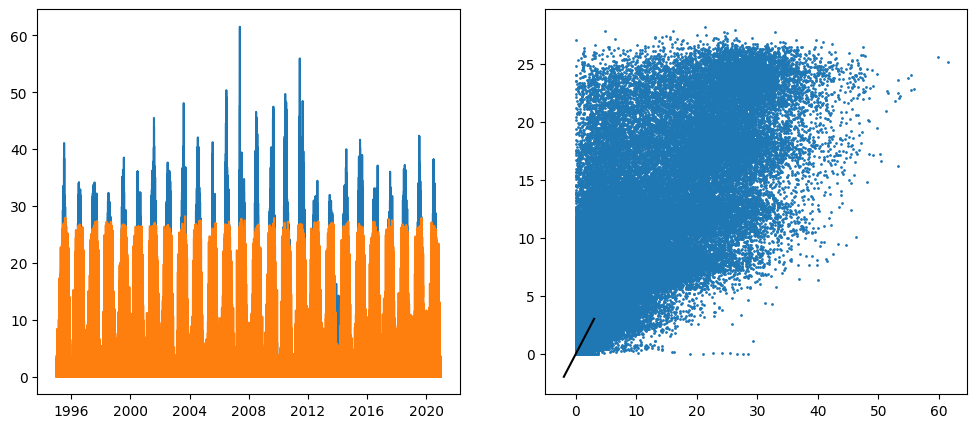

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(y_test.index, y_test.values)
ax1.plot(y_test.index, rfr.predict(X_test))
ax2.scatter(y_test.values, rfr.predict(X_test), s=1)
ax2.plot([-2, 3], [-2, 3], c="k")

Save model to ONNX

In [15]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import numpy as np

With `skl2onnx` we can easily convert our random forest regressor to onnx model.

Note that the user needs to tell the converter the initial type of input. For instance,
`initial_types=[('X', FloatTensorType([None, X_test.shape[1]]))])`
indicates that input name will be `X`, input type is `FloatTensorType`, the batch size is unknown (`None`) and the number of channels are `X_test.shape[1]`.

More details can be found in the API summary:
https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.convert_sklearn

In [16]:
onx = convert_sklearn(
    rfr, initial_types=[('X', FloatTensorType((None, X_test.shape[1])))])

with open("rfr.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [17]:
from onnxruntime import InferenceSession

def predict_with_onnxruntime(onx, X):
    sess = InferenceSession(onx.SerializeToString())
    input_name = sess.get_inputs()[0].name
    res = sess.run(None, {input_name: X.astype(np.float32)})
    return res[0]

Verify saved model.

In [25]:
print(predict_with_onnxruntime(onx, X_test.to_numpy())[:10])

[[0.0000e+00]
 [5.8845e-06]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]]


In [28]:
rfr.predict(X_test)[:10]

array([0.0000e+00, 5.8845e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])